In [4]:
import re
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.utils import to_categorical

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import nltk
nltk.download('wordnet')
nltk.data.path.append('Data/')
print(nltk.data.path)

['C:\\Users\\admin/nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\\share\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\\lib\\nltk_data', 'C:\\Users\\admin\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data', 'Data/']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def retrieve_articles_from_csv(file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(file_path)
    
    # Chuyển đổi DataFrame thành danh sách các từ điển (records)
    articles = df.to_dict(orient='records')
    
    return articles

In [7]:
import re
import string


def preprocess_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

<>:7: SyntaxWarning: invalid escape sequence '\['
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\['
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\w'
C:\Users\admin\AppData\Local\Temp\ipykernel_13520\897105695.py:7: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
C:\Users\admin\AppData\Local\Temp\ipykernel_13520\897105695.py:9: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
C:\Users\admin\AppData\Local\Temp\ipykernel_13520\897105695.py:13: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [8]:
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        synonyms = wordnet.synsets(word)
        if synonyms:
            new_words[i] = synonyms[0].lemmas()[0].name()
    return ' '.join(new_words)



In [9]:
def cross_validation(model, X, y):
    scores = cross_val_score(model, X, y, cv=5)
    print(f"Cross-validation Accuracy: {np.mean(scores)}")

In [10]:
# def build_lstm_model(vocab_size, embedding_dim, input_length):
#     model = Sequential()
#     model.add(Input(shape=(input_length,)))  # Thêm lớp Input với kích thước đầu vào
#     model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
#     model.add(LSTM(100, return_sequences=True))
#     model.add(LSTM(100))
#     model.add(Dense(2, activation='softmax'))
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

Thống kê dữ liệu từ bộ DB từ đó tiền xử lý dữ liệu

In [11]:
import pandas as pd

# Hàm chính# Đọc dữ liệu từ file CSV
df = pd.read_csv('Data/VFND-vietnamese-fake-news-datasets/CSV/vn_news_226_tlfr.csv')

# Kiểm tra tên các cột trong DataFrame
print("Tên các cột trong DataFrame:", df.columns)

# Tiền xử lý và mở rộng văn bản
df['processed_text'] = df['text'].apply(preprocess_text)  # Tiền xử lý văn bản gốc
df['augmented_text'] = df['processed_text'].apply(synonym_replacement)  # Mở rộng văn bản với thay thế từ đồng nghĩa
# Kết hợp văn bản gốc và văn bản mở rộng vào một DataFrame mới
df_combined = pd.concat([
    df[['processed_text']].rename(columns={'processed_text': 'text'}),
    df[['augmented_text']].rename(columns={'augmented_text': 'text'})
], axis=0, ignore_index=True)

# Thêm nhãn vào DataFrame kết hợp
df_combined['label'] = df['label'].tolist() * 2 # Nhân đôi nhãn để phù hợp với số lượng văn bản kết hợp
# Chuẩn bị dữ liệu đầu vào và nhãn cho mô hình
X = df_combined['text']  # Văn bản đầu vào cho mô hình
y = df_combined['label']  # Nhãn tương ứng


Tên các cột trong DataFrame: Index(['text', 'label'], dtype='object')


Thống kê bộ dữ liệu

In [12]:
# Kiểm tra đầu ra
print("Phân bố nhãn sau khi kết hợp:")
print(y.value_counts())
print("================================================================")
print("Dữ liệu đầu vào (X):")
print(X.head(451))
print("================================================================")
print("Nhãn (y):")
print( y.head(451))

Phân bố nhãn sau khi kết hợp:
label
0    246
1    206
Name: count, dtype: int64
Dữ liệu đầu vào (X):
0      thủ tướng abe cúi đầu xin lỗi vì hành động phi...
1      thủ tướng nhật cúi đầu xin lỗi vì tinh thần ph...
2      choáng  cơ trưởng đeo khăn quàng quẩy banh nóc...
3      chưa bao giờ nhạc kpop lại dễ hát đến thế    g...
4      đại học hutech sẽ áp dụng cải cách  tiếq việt ...
                             ...                        
446    trường sơn giành hcv tại giải cờ vua đồng đội ...
447    chuyện về chàng sinh viên luật kiện tướng lê t...
448    tiền đạo Malaysia tôi đã có cách vượt qua hàng...
449    các bạn tin không miễn phí chiến dịch quảng bá...
450    thân gởi các bạn yêu quý tôi nghĩ các bạn nên ...
Name: text, Length: 451, dtype: object
Nhãn (y):
0      1
1      1
2      1
3      1
4      1
      ..
446    0
447    0
448    0
449    1
450    1
Name: label, Length: 451, dtype: int64


In [13]:
df.isnull().sum()

text              0
label             0
processed_text    0
augmented_text    0
dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_13520\4035595335.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_combined, palette='viridis')


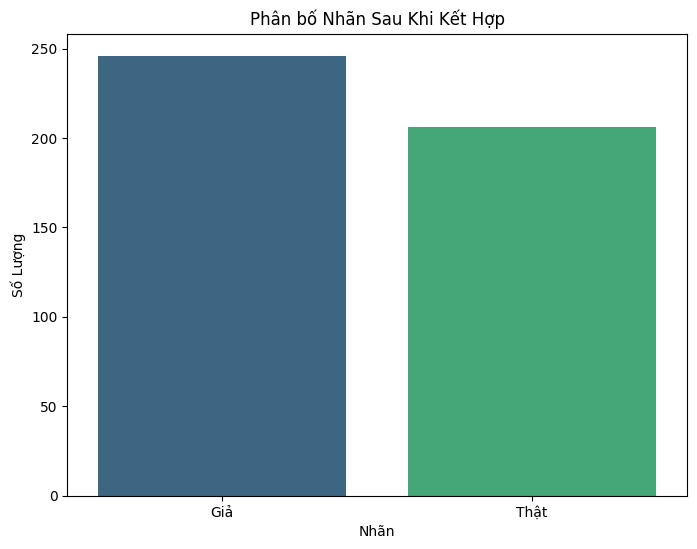

In [14]:
# Vẽ biểu đồ tròn để trực quan hóa phân bố nhãn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_combined, palette='viridis')
plt.title('Phân bố Nhãn Sau Khi Kết Hợp')
plt.xlabel('Nhãn')
plt.ylabel('Số Lượng')
plt.xticks(ticks=[0, 1], labels=['Giả', 'Thật'])  # Thay đổi nhãn nếu cần thiết
plt.show()

Sử dụng mô hình PhoBert để Train cho bài toán

In [213]:
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--vinai--phobert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaFo

Xử lý Mapping dataset vào mô hình

In [214]:
def preprocess_data(X, tokenizer, max_len=256):
    input_ids, attention_masks = [], []

    for sentence in X:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      
            add_special_tokens=True,       
            max_length=max_len,            
            pad_to_max_length=True,
            return_attention_mask=True,    
            return_tensors='pt',           
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks
    
X_input_ids, X_attention_masks = preprocess_data(X, tokenizer)
y_tensor = torch.tensor(y.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Thiết lập các thông số cần thiết

In [215]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(X_input_ids, y_tensor, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(X_attention_masks, X_input_ids, test_size=0.2, random_state=42)


In [216]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Model cho bài toán 

In [218]:
epochs = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()        

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss for epoch {epoch}: {avg_train_loss}")

    # Validation
    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).flatten()

        val_accuracy += (predictions == b_labels).cpu().numpy().mean()

    val_accuracy /= len(val_dataloader)
    print(f"Validation accuracy for epoch {epoch}: {val_accuracy}")

# Save the model
model.save_pretrained('phobert_fake_news_model')
tokenizer.save_pretrained('phobert_fake_news_model')


Average training loss for epoch 0: 0.3009901454915171
Validation accuracy for epoch 0: 0.9535984848484849
Average training loss for epoch 1: 0.10161460490654343
Validation accuracy for epoch 1: 0.9640151515151515
Average training loss for epoch 2: 0.05278598824920862
Validation accuracy for epoch 2: 0.9744318181818182
Average training loss for epoch 3: 0.08625260720272428
Validation accuracy for epoch 3: 0.9791666666666666


('phobert_fake_news_model\\tokenizer_config.json',
 'phobert_fake_news_model\\special_tokens_map.json',
 'phobert_fake_news_model\\vocab.txt',
 'phobert_fake_news_model\\bpe.codes',
 'phobert_fake_news_model\\added_tokens.json')

Sử dụng TF-IDF với Logistic Regression

In [200]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)
    
model_lr = LogisticRegression()
cross_validation(model_lr, X_tfidf, y)

Cross-validation Accuracy: 0.9336752136752138


Chia tập huấn luyện và đánh giá Logistic Regression

In [201]:

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
    
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.9557522123893806
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96        55
           1       0.98      0.93      0.96        58

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



Tiền xử lý dữ liệu

In [202]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# Chuyển đổi nhãn thành định dạng phân loại
y_categorical = to_categorical(y, num_classes=2)

Xây dựng mô hình

In [203]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
input_length = 500# Đây là chiều dài tối đa của chuỗi đầu vào
model_lstm = build_lstm_model(vocab_size=vocab_size, embedding_dim=embedding_dim, input_length=input_length)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Định nghĩa callback để lưu trọng số tốt nhất
checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Định nghĩa callback để dừng sớm khi độ hội tụ đạt yêu cầu
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1, mode='min')

# Huấn luyện mô hình với các callback
model_lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

# Lưu mô hình hoàn chỉnh sau khi huấn luyện
model_lstm.save('fake_news_model.h5')

Đánh giá mô hình LSTM

In [204]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {accuracy}")

Tìm và quét các bài báo trên nguồn VNExpress và lưu và MongoDB

In [205]:
import requests
from bs4 import BeautifulSoup
from pymongo import MongoClient

def scrape_vnexpress_news():
    url = 'https://vnexpress.net/tin-tuc-24h'
    response = requests.get(url)
    
    if response.status_code != 200:
        print("Failed to retrieve the webpage")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    articles = []
    
    for item in soup.find_all('article', class_='item-news'):
        title = item.find('h3', class_='title-news')
        link = item.find('a', href=True)
        summary = item.find('p', class_='description')
        
        if title and link and summary:
            full_link = link['href']
            if not full_link.startswith('http'):
                full_link = 'https://vnexpress.net' + full_link
            articles.append({
                'title': title.get_text(strip=True),
                'link': full_link,
                'summary': summary.get_text(strip=True),
                'label': 0
            })
    
    return articles

In [206]:
# Lấy dữ liệu từ trang VNExpress
articles = scrape_vnexpress_news()
for article in articles:
    print(article)

Truy vết từ MongoDB và dự đoán các bài báo Fake (Fake_News)

In [16]:
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pymongo import MongoClient
import torch

# Hàm tiền xử lý văn bản mới (Dùng tokenizer của Hugging Face)
def preprocess_new_text(text, tokenizer, max_length=500):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    return inputs

# Dự đoán tin tức mới
def predict_fake_news(text, model, tokenizer, max_length=500):
    inputs = preprocess_new_text(text, tokenizer, max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return "Thật" if prediction == 1 else "Giả"

# Load the model and tokenizer
model_name = "phobert_fake_news_model/"  # Replace with your model directory or identifier
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Kết nối đến MongoDB và lấy dữ liệu bài báo
client = MongoClient('mongodb://localhost:27017')
db = client['news_database']
collection = db['VNExpress_news']

# Đọc dữ liệu từ MongoDB vào DataFrame
df_articles = pd.DataFrame(list(collection.find()))

# Dự đoán cho các bài báo
df_articles['predicted_label'] = df_articles['summary'].apply(lambda x: predict_fake_news(x, model, tokenizer))

# Thống kê số lượng bài báo thật và giả
true_count = (df_articles['predicted_label'] == "Thật").sum()
fake_count = (df_articles['predicted_label'] == "Giả").sum()

print(f"Số bài báo thật: {true_count}")
print(f"Số bài báo giả: {fake_count}")

# Lọc và in ra chi tiết các bài báo giả
print('Chi tiết các fake_news')
fake_articles = df_articles[df_articles['predicted_label'] == "Giả"]
for index, row in fake_articles.iterrows():
    print(f"ID bài báo: {row['_id']}")
    print(f"Tiêu đề: {row.get('title', 'Không có tiêu đề')}")
    print(f"Tóm tắt: {row['summary']}")
    print(f"Đường dẫn: {row.get('link', 'Không có link')}")
    print("-" * 40)

# Đóng kết nối MongoDB
client.close()


Số bài báo thật: 24
Số bài báo giả: 66
Chi tiết các fake_news
ID bài báo: 66bf0e353febf8c28e68b8c1
Tiêu đề: Đường golf dưới lưới điện Mỹ
Tóm tắt: Một golfer ở South Carolina tận dụng khu đất trống ngay bên dưới đường truyền tải điện phía sau nhà để làm đường golf phục vụ gia đình và láng giềng.
Đường dẫn: https://vnexpress.net/duong-golf-duoi-luoi-dien-my-4782291.html
----------------------------------------
ID bài báo: 66bf0e353febf8c28e68b8c2
Tiêu đề: Đảo Jeju giảm khách giữa lùm xùm 'chặt chém'
Tóm tắt: Hàn QuốcLượng khách trong nước đến đảo Jeju giảm vào cao điểm hè, trong bối cảnh có nhiều phàn nàn món đặc sản thịt lợn đen bị bán "chặt chém".
Đường dẫn: https://vnexpress.net/dao-jeju-giam-khach-giua-lum-xum-chat-chem-4782084.html
----------------------------------------
ID bài báo: 66bf0e353febf8c28e68b8c3
Tiêu đề: Khó ngủ, điều trị thế nào?
Tóm tắt: Trước đây tôi làm ca tối nên đi ngủ lúc 4-5h, khoảng 13h-14h dậy. Nay tôi đã đổi việc, làm giờ hành chính nhưng bị khó ngủ, có uống 

Một ví dụ cho dự đoán Fake_News

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("phobert_fake_news_model/")
tokenizer = AutoTokenizer.from_pretrained("phobert_fake_news_model/")

# Preprocess and predict
def predict_fake_news_hf(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=500)
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Thật" if prediction == 1 else "Giả"

# Ví dụ về văn bản tin tức mới
new_texts = [
    "Tối 3/6, trong giờ cao điểm, trên đường Đống Đa (quận Hải Châu, Đà Nẵng) dòng người đi xe máy nối đuôi nhau đi ngược nhiều. Nhiều ôtô cũng chạy lấn sang làn đối diện để vượt lên. Những người này đã bị tài xế ôtô gắn camera hành trình ép lùi và nhập vào đúng phần đường của mình.",
    "Việt Nam có 54 dân tộc anh em",
    "Uống 2 lít nước lọc hằng ngày tốt cho sức khỏe"
]

# Example predictions
predictions = [predict_fake_news_hf(text) for text in new_texts]

for text, prediction in zip(new_texts, predictions):
    print(f"Tin tức: {text}\nDự đoán: {prediction}\nĐộ dài: {len(text)}\n")


Tin tức: Tối 3/6, trong giờ cao điểm, trên đường Đống Đa (quận Hải Châu, Đà Nẵng) dòng người đi xe máy nối đuôi nhau đi ngược nhiều. Nhiều ôtô cũng chạy lấn sang làn đối diện để vượt lên. Những người này đã bị tài xế ôtô gắn camera hành trình ép lùi và nhập vào đúng phần đường của mình.
Dự đoán: Giả
Độ dài: 278

Tin tức: Việt Nam có 54 dân tộc anh em
Dự đoán: Thật
Độ dài: 29

Tin tức: Uống 2 lít nước lọc hằng ngày tốt cho sức khỏe
Dự đoán: Thật
Độ dài: 46



In [18]:
import requests
from bs4 import BeautifulSoup
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Tải mô hình và tokenizer
model = AutoModelForSequenceClassification.from_pretrained("phobert_fake_news_model/")
tokenizer = AutoTokenizer.from_pretrained("phobert_fake_news_model/")

# Hàm trích xuất nội dung văn bản từ một URL
def extract_text_from_url(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Giả định rằng nội dung bài báo nằm trong các thẻ <p>
    paragraphs = soup.find_all('p')
    text = '\n'.join([para.get_text() for para in paragraphs])
    return text

# Hàm dự đoán tin giả cho một đoạn văn
def predict_fake_news_hf(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=500)
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Thật" if prediction == 1 else "Giả"

# Hàm quét toàn bộ bài báo
def scan_article_for_fake_news(url):
    # Trích xuất văn bản từ bài báo
    article_text = extract_text_from_url(url)
    paragraphs = article_text.split('\n')
    
    fake_paragraphs = []
    total_paragraphs = len(paragraphs)
    
    # Dự đoán từng đoạn văn
    for paragraph in paragraphs:
        if paragraph.strip():  # Đảm bảo đoạn văn không trống
            result = predict_fake_news_hf(paragraph)
            if result == "Giả":
                fake_paragraphs.append(paragraph)

    # Tính toán phần trăm tin giả
    fake_percentage = (len(fake_paragraphs) / total_paragraphs) * 100
    
    # Xuất kết quả
    print(f"Phần trăm tin giả trong bài báo: {fake_percentage:.2f}%\n")
    
    if fake_paragraphs:
        print("Các đoạn văn là tin giả:\n")
        for i, para in enumerate(fake_paragraphs, 1):
            print(f"Đoạn văn {i}: {para}\n")
    else:
        print("Không phát hiện tin giả trong bài báo này.")

# Ví dụ sử dụng
url = "https://ngoisao.vnexpress.net/cuoc-song-mc-quynh-chi-truoc-khi-ket-hon-o-tuoi-38-4784423.html"  # Thay bằng URL thực tế của bài báo
scan_article_for_fake_news(url)


Phần trăm tin giả trong bài báo: 48.39%

Các đoạn văn là tin giả:

Đoạn văn 1: Trước khi lấy chồng, MC Quỳnh Chi vắng bóng truyền hình, tập trung kinh doanh, phát triển thương hiệu thời trang riêng.

Đoạn văn 2: Hôm 22/8, Quỳnh Chi cho biết đã thử xong váy cưới, đang cùng bạn trai hoàn thiện những khâu cuối cho hôn lễ dự kiến diễn ra vào tháng 10. 

Đoạn văn 3: Hôm 22/8, Quỳnh Chi cho biết đã thử xong váy cưới, đang cùng bạn trai hoàn thiện những khâu cuối cho hôn lễ dự kiến diễn ra vào tháng 10. 

Đoạn văn 4: Thời gian qua, Quỳnh Chi chỉ tham gia một số chương trình đặc biệt, phần lón thời gian dành để phát triển sự nghiệp thiết kế, thương hiệu riêng. Cô nói bước đi này không phải là sự bốc đồng mà nằm trong tính toán từ lâu. 

Đoạn văn 5: Thời gian qua, Quỳnh Chi chỉ tham gia một số chương trình đặc biệt, phần lón thời gian dành để phát triển sự nghiệp thiết kế, thương hiệu riêng. Cô nói bước đi này không phải là sự bốc đồng mà nằm trong tính toán từ lâu. 

Đoạn văn 6: Thỉnh thoảng, 